In [16]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from mpl_toolkits import mplot3d

In [17]:
print(plt.rcParams["figure.figsize"])
backupPlotSize = [6.0, 4.0]

[6.0, 4.0]


## 1. Disparity

### 1. a) Derive 

### 1.b) Compute disparity

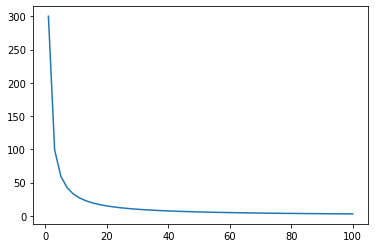

In [18]:
focLen = 2.5
camBaseline = 120
z = np.linspace(1,100)

disparity = (focLen*camBaseline) / z

plt.plot(z, disparity)

### 1.c) Spet neki analiticnega

### 2.d) Disparity image pair


(416, 607) (416, 607)
(416, 607)
(607,)


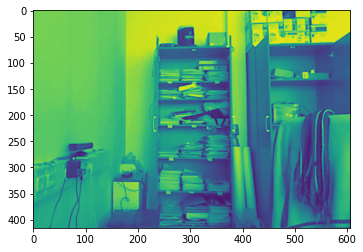

In [19]:
#patch size bo 20

def getDisparity(img1, img2):
    height, width = img1.shape

    N=5

    mean1 = np.mean(img1)
    mean2 = np.mean(img2)

    
    dif1 = img1 - mean1
    dif2 = img2 - mean2

    print(dif1.shape)

    # for i in range(height):
    #     for j in range(width):


    ncc = sum(dif1*dif2)/ (N*np.sqrt((1/N) * np.sum(dif1**2)) * (N*np.sqrt((1/N) * np.sum(dif2**2))))

    print(ncc.shape)



office1= cv2.imread("data\disparity\office2_left.png", cv2.IMREAD_GRAYSCALE)
office2= cv2.imread("data\disparity\office_right.png", cv2.IMREAD_GRAYSCALE)

print(office1.shape, office2.shape)

plt.imshow(office1)

getDisparity(office1, office2)


## 2. Fundamental matrix, epipoles, epipolar lines

### 2.a) Fundamental matrix

In [20]:
def normalize_points(P):
	mu = np.mean(P, axis=0) # mean
	scale = np.sqrt(2) / np.mean(np.sqrt(np.sum((P-mu)**2,axis=1))) # scale
	T = np.array([[scale, 0, -mu[0]*scale],[0, scale, -mu[1]*scale],[0,0,1]]) # transformation matrix
	P = np.hstack((P,np.ones((P.shape[0],1)))) # homogeneous coordinates
	res = np.dot(T,P.T).T
	return res, T





points=np.loadtxt("data/epipolar/house_points.txt")
pointsL = points[:,0:2]
pointsR = points[:,2:]


def fundamentalMatrix(pointsL, pointsR):
	#sam pazi da nimas kle v homogenih
	pointsL = pointsL[:, 0:2]
	pointsR = pointsR[:, 0:2]

	normLeft, TLeft= normalize_points(pointsL)
	normRight, TRight= normalize_points(pointsR)

	#get each coordinate
	xL= normLeft[:,0]
	yL = normLeft[:,1]
	xR = normRight[:,0]
	yR = normRight[:,1]

	#build matrix for the system of equations
	matrix = np.zeros((len(xL), 9))

	for i in range(len(xL)):
		matrix[i,:] = np.array([xL[i]*xR[i], xL[i]*yR[i], xL[i], yL[i]*xR[i], yL[i]*yR[i], yL[i], xR[i], yR[i], 1])

	u, s, vh = np.linalg.svd(matrix, full_matrices=True)
	vt = vh.T

	#compute the fundamental matrix Ft
	ft=vt[:,-1]
	ft=ft.reshape(3,3)

	#rank reduction
	u,s,vh = np.linalg.svd(ft, full_matrices=True)

	#set the last eigen value to 0
	s[-1] = 0

	#if we want to reconstruct the matrix, s needs to be a matrix and not a vector
	#F = np.matmul(np.matmul(u,np.identity(3)*s),vh)
	F = u@np.identity(3)*s@vh #krajse za matrix multiplication

	# print(ft)
	# print(F)

	vh = vh.T

	epiPole1 = vh[:,2] / vh[2,2]
	epiPole2 = u[:,2] / u[2,2]

	#print(epiPole1, epiPole2)
	#TOLE JE mal CUDN, ampak da praviln F!!!
	Ftrue = np.matmul(np.matmul(TLeft.T, F), TRight)

	#Ftrue = Ftrue = np.matmul(np.matmul(TRight.T, F), TLeft)


	return Ftrue, epiPole1, epiPole2

#print(Ftrue.T)

#print(s)


solution = np.loadtxt("data/epipolar/house_fundamental.txt")
#print(solution)


### 2.b)

In [21]:
def draw_epiline(l,h,w):
	# l: line
	# h: image height
	# w: image width

	x0, y0 = map(int, [0, -l[2]/l[1]])
	x1, y1 = map(int, [w-1, -(l[2]+l[0]*w)/l[1]])

	plt.plot([x0,x1],[y0,y1],'r')

	plt.ylim([0,h])
	plt.gca().invert_yaxis()

[ 4.57180335e-04  9.79073013e-03 -2.00968914e+00]


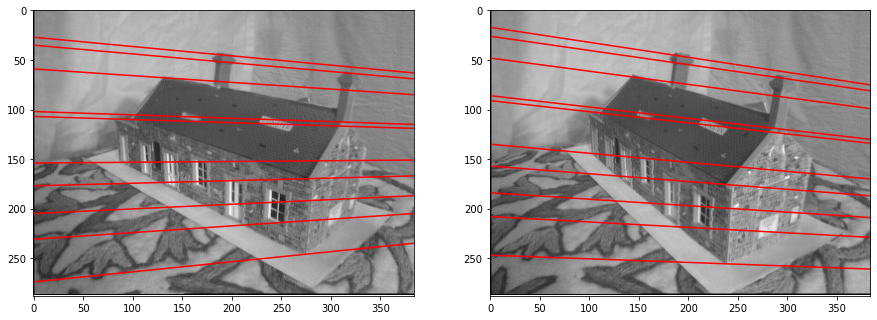

In [22]:
F, e1, e2 = fundamentalMatrix(pointsL, pointsR)

plt.rcParams["figure.figsize"] = [15,10]
house1 = cv2.imread("data/epipolar/house1.jpg")
house1 = cv2.cvtColor(house1, cv2.COLOR_BGR2GRAY)

house2 = cv2.imread("data/epipolar/house2.jpg")
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2GRAY)

plt.subplot(121)
plt.imshow(house1, cmap="gray")

plt.subplot(122)
plt.imshow(house2, cmap="gray")

#plot all the lines in both images
for i in range(len(pointsL)):

    #draw the line on the right image corresponding to the point in the left image
    coordPoint = np.append(pointsL[i,:],1)
    #epipolar line for second image
    l2 = F.T@coordPoint #KLE GA TRANSPONIRAS !
    height, width = house2.shape
    plt.subplot(122)
    draw_epiline(l2,height, width)

    #draw the line on the left image corresponding to the point in the right image
    coordPoint = np.append(pointsR[i,:],1)
    l1 = F@coordPoint #kle pa ni transponiran
    height, width = house1.shape
    plt.subplot(121)
    draw_epiline(l1,height, width)

# coordPoint = np.append(pointsR[5,:],1)
# l1 = F@coordPoint
# height, width = house1.shape
# plt.subplot(121)
# draw_epiline(l1,height, width)

print(l1)

plt.rcParams["figure.figsize"] = backupPlotSize


In [23]:
#calculates the reprojectionEror between two matching points pt1 and pt2, F is a fundamental matrix
def reprojectionError(pt1, pt2, F):
    l1=F@pt2
    dist1 = np.abs(np.dot(l1,pt1))/np.sqrt(l1[0]**2 + l1[1]**2)

    l2=F.T@pt1
    dist2 = np.abs(np.dot(l2,pt2))/np.sqrt(l2[0]**2 + l2[1]**2)

    return (dist1 + dist2)/2

# pt1 = [85,233,1]
# pt2 = [67,219,1]

# error = reprojectionError(pt1, pt2, F)
# print(error)

#returns  the average error of points and fundamental matrix
def averageErrorPoints(pts1, pts2, F):
    avg = 0
    n = len(pts1)
    
    for i in range(n):
        avg += reprojectionError(pts1[i], pts2[i], F)
    return avg / n


#adds an extra column of ones to the x,y points
pointsL1 = np.c_[pointsL, np.ones((len(pointsL)))]
pointsR1 = np.c_[pointsR, np.ones((len(pointsR)))]

avgError = averageErrorPoints(pointsL1, pointsR1, F)
print(avgError)


0.33091336980540825


### RANSAC

In [24]:
def getInliers(F, pts1, pts2, thresh):
    n=len(pts1)
    
    #select only corresponding points, that are inliers
    inlrs1 =[] #np.empty((0,3))
    inlrs2 = [] # np.empty((0,3))

    for i in range(n):
        l1=F@pts2[i]
        dist1 = np.abs(np.dot(l1,pts1[i]))/np.sqrt(l1[0]**2 + l1[1]**2)

        l2=F.T@pts1[i]
        dist2 = np.abs(np.dot(l2,pts2[i]))/np.sqrt(l2[0]**2 + l2[1]**2)

        err = (dist1 + dist2)/2

        if (dist1 < thresh and dist2 < thresh):
            inlrs1.append(pts1[i])
            inlrs2.append(pts2[i])
    
    return np.array(inlrs1), np.array(inlrs2)

        

```

Given:
    data – A set of observations.
    model – A model to explain observed data points.
    n – Minimum number of data points required to estimate model parameters.
    k – Maximum number of iterations allowed in the algorithm.
    t – Threshold value to determine data points that are fit well by model.
    d – Number of close data points required to assert that a model fits well to data.

Return:
    bestFit – model parameters which best fit the data (or null if no good model is found)

iterations = 0
bestFit = null
bestErr = something really large

while iterations < k do
    maybeInliers := n randomly selected values from data
    maybeModel := model parameters fitted to maybeInliers
    alsoInliers := empty set
    for every point in data not in maybeInliers do
        if point fits maybeModel with an error smaller than t
             add point to alsoInliers
        end if
    end for
    if the number of elements in alsoInliers is > d then
        // This implies that we may have found a good model
        // now test how good it is.
        betterModel := model parameters fitted to all points in maybeInliers and alsoInliers
        thisErr := a measure of how well betterModel fits these points
        if thisErr < bestErr then
            bestFit := betterModel
            bestErr := thisErr
        end if
    end if
    increment iterations
end while

return bestFit
```

0.2098336459487916
[[-5.88273684e-08  4.54049475e-06 -8.63355645e-05]
 [ 7.97938669e-07 -3.54126396e-07  1.04657533e-02]
 [ 1.30473224e-04 -1.13982065e-02 -1.00709819e-02]]


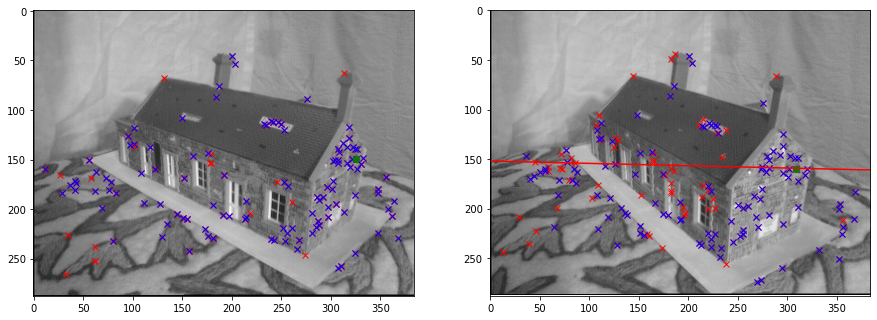

In [43]:
def ransacFundamental(points, thresh, minInliers, k):
    a=0
    bestError = 10000
    bestF = np.identity(3)
    bestInlrs1 = np.array(())
    bestInlrs2 = np.array(())

    pointsL = points[:,0:2]
    pointsR = points[:,2:]
    #dej v homogene
    pointsL = np.c_[pointsL, np.ones((len(pointsL)))]
    pointsR = np.c_[pointsR, np.ones((len(pointsR)))] 

    for i in range(k):
        indexesPoints = np.random.choice(len(points), size=8, replace=False)

        #select n random points
        #maybeInliers = points[indexesPoints]

        maybeInliersL = pointsL[indexesPoints]
        maybeInliersR = pointsR[indexesPoints]

        fund,e1,e2 = fundamentalMatrix(maybeInliersL, maybeInliersR)

        inlrs1, inlrs2 = getInliers(fund, pointsL, pointsR, thresh)

        #pregledas ce mas zadost inlierjov
        if len(inlrs1)/len(pointsL) >= minInliers:
            fund,e1,e2 = fundamentalMatrix(inlrs1, inlrs2)
            #if(len(inlrs1) == 8):
                #print(F)
            err = averageErrorPoints(inlrs1, inlrs2, fund)
            #print(err)
            if (err < bestError):
                bestError = err
                bestF = fund
                bestInlrs1 = inlrs1
                bestInlrs2 = inlrs2

    return bestF, bestInlrs1, bestInlrs2, bestError

points=np.loadtxt("data/epipolar/house_matches.txt")

F, bestInlrs1, bestInlrs2, err = ransacFundamental(points, 2, 0.5, 100)

pointsL = points[:,0:2]
pointsR = points[:,2:]

plt.rcParams["figure.figsize"] = [15,10]
plt.subplot(121)
plt.imshow(house1, cmap="gray")



plt.subplot(122)
plt.imshow(house2, cmap="gray")
plt.rcParams["figure.figsize"] = backupPlotSize

print(err)

for i in range(len(pointsL)):
    plt.subplot(121)
    plt.plot(pointsL[i,0], pointsL[i,1], 'rx')
    
    plt.subplot(122)
    plt.plot(pointsR[i,0], pointsR[i,1], 'rx')

for i in range(len(bestInlrs1)):
    plt.subplot(121)
    plt.plot(bestInlrs1[i,0], bestInlrs1[i,1], 'bx')
    
    plt.subplot(122)
    plt.plot(bestInlrs2[i,0], bestInlrs2[i,1], 'bx')


selPoint = np.random.randint(0, len(bestInlrs1)-1)
plt.subplot(121)
plt.plot(bestInlrs1[selPoint,0], bestInlrs1[selPoint,1], 'go')
coordPoint = bestInlrs1[selPoint,:]
#epipolar line for second image
l2 = F.T@coordPoint #KLE GA TRANSPONIRAS !
height, width = house2.shape
plt.subplot(122)
plt.plot(bestInlrs2[selPoint,0], bestInlrs2[selPoint,1], 'go')
draw_epiline(l2,height, width)

    
print(F)

e=5
n=8
k=100




0.21218860915570312
[[-4.75591597e-08  4.32989993e-06 -7.62812650e-05]
 [ 8.73917582e-07 -3.93189865e-07  1.00672906e-02]
 [ 1.03004713e-04 -1.09607349e-02 -8.04889146e-03]]


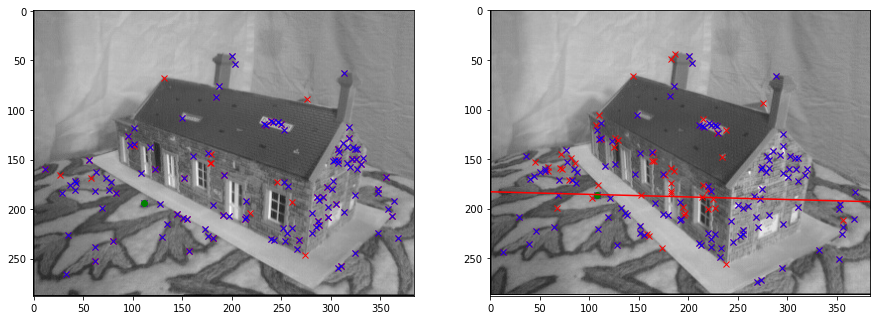

In [26]:
points=np.loadtxt("data/epipolar/house_matches.txt")

F, bestInlrs1, bestInlrs2, err = ransacFundamental(points, 2, 0.5, 100)

pointsL = points[:,0:2]
pointsR = points[:,2:]

plt.rcParams["figure.figsize"] = [15,10]
plt.subplot(121)
plt.imshow(house1, cmap="gray")



plt.subplot(122)
plt.imshow(house2, cmap="gray")
plt.rcParams["figure.figsize"] = backupPlotSize

print(err)

for i in range(len(pointsL)):
    plt.subplot(121)
    plt.plot(pointsL[i,0], pointsL[i,1], 'rx')
    
    plt.subplot(122)
    plt.plot(pointsR[i,0], pointsR[i,1], 'rx')

for i in range(len(bestInlrs1)):
    plt.subplot(121)
    plt.plot(bestInlrs1[i,0], bestInlrs1[i,1], 'bx')
    
    plt.subplot(122)
    plt.plot(bestInlrs2[i,0], bestInlrs2[i,1], 'bx')


selPoint = 12
plt.subplot(121)
plt.plot(bestInlrs1[selPoint,0], bestInlrs1[selPoint,1], 'go')
coordPoint = bestInlrs1[selPoint,:]
#epipolar line for second image
l2 = F.T@coordPoint #KLE GA TRANSPONIRAS !
height, width = house2.shape
plt.subplot(122)
plt.plot(bestInlrs2[selPoint,0], bestInlrs2[selPoint,1], 'go')
draw_epiline(l2,height, width)

    
print(F)

e=5
n=8
k=100

### 2.f) Robust homography

In [27]:
#get random indexes for our data
indexesPoints = np.random.choice(20, size=8, replace=False)

test = np.arange(16).reshape(4,4)
print(test)



b=[]

b.append(test[0,:])
b.append(test[1,:])

b=np.array(b)

print(b)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[0 1 2 3]
 [4 5 6 7]]


### 2.g) Robust homography

In [28]:
pan1 = cv2.imread("data/panorama/panorama1.jpg")
pan1 = cv2.cvtColor(pan1, cv2.COLOR_BGR2GRAY)
pan1 = pan1[0:222, 0:305]

pan2 = cv2.imread("data/panorama/panorama2.jpg")
pan2 = cv2.cvtColor(pan2, cv2.COLOR_BGR2GRAY)
pan2 = pan2[0:222, 0:305]

pan3 = cv2.imread("data/panorama/panorama3.jpg")
pan3 = cv2.cvtColor(pan3, cv2.COLOR_BGR2GRAY)
pan3 = pan3[0:222, 0:305]

pan4 = cv2.imread("data/panorama/panorama4.jpg")
pan4 = cv2.cvtColor(pan4, cv2.COLOR_BGR2GRAY)
pan4 = pan4[0:222, 0:305]

pan5 = cv2.imread("data/panorama/panorama5.jpg")
pan5 = cv2.cvtColor(pan5, cv2.COLOR_BGR2GRAY)
pan5 = pan5[0:222, 0:305]

pan6 = cv2.imread("data/panorama/panorama6.jpg")
pan6 = cv2.cvtColor(pan6, cv2.COLOR_BGR2GRAY)
pan6 = pan6[0:222, 0:305]

print(pan1.shape, pan2.shape, pan3.shape, pan4.shape, pan5.shape, pan6.shape)

(222, 305) (222, 305) (222, 305) (222, 305) (222, 305) (222, 305)


### 2.g)

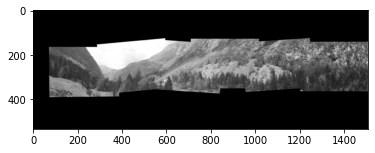

In [29]:

def getGaussianKernel(stDev):
    kerSize = int(2*3*stDev + 1)
    x=np.arange(-(kerSize // 2),(kerSize // 2)+1 )
    gaus = np.exp(-(x**2)/(2*stDev**2))/ (np.sqrt(2*np.pi)*stDev)
    #gaus=(1/np.sqrt(2*np.pi*stDev)) * np.exp(-(x*x/(2*stDev*stDev)))
    gaus = gaus/sum(gaus)
    return np.array([gaus])


def getGaussianDx(stDev):
    kerSize = int(6*stDev + 1)
    x=np.arange(-(kerSize // 2),(kerSize // 2)+1 )
    gaus = -x*np.exp(-(x*x)/(2*stDev*stDev))/ (np.sqrt(2*np.pi)*stDev*stDev*stDev)
    gaus = gaus/sum(np.abs(gaus))
    return np.array([gaus])

#dva filtra da, ful packasto uglavnem
def applyFilter2(image, kernel1, kernel2):
    kernel1 = np.flip(kernel1)
    kernel2 = np.flip(kernel2)

    imageFiltered = cv2.filter2D(image, ddepth=-1, kernel=kernel1)
    imageFiltered = cv2.filter2D(imageFiltered, ddepth=-1, kernel=kernel2)

    return imageFiltered

def applyFilter(image, kernel):
    #dvakrat gremo skoz, enkrat transponiramo namest n^2 -> 2n
    imageFiltered = cv2.filter2D(image, ddepth=-1, kernel=kernel)
    imageFiltered = cv2.filter2D(imageFiltered, ddepth=-1, kernel=kernel.T)

    return imageFiltered



def getSecondDerivative(img, sigma):
    g = getGaussianKernel(sigma)
    d = getGaussianDx(sigma)

    # np.flip(g)
    # np.flip(d)

    Ix = cv2.filter2D(img, cv2.CV_32F, g.T)
    Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

    Iy = cv2.filter2D(img, cv2.CV_32F, g)
    Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

    Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
    Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

    Ixy=cv2.filter2D(Ix,  cv2.CV_32F, g)
    Ixy = cv2.filter2D(Ixy, cv2.CV_32F, d.T)

    Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
    Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

    return Ixx, Ixy, Iyy

def hessianPoints(img, sigma, thresh):
    img=np.copy(img)
    img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
    # gausKer = getGaussianKernel(sigma)
    # gausKerDx = getGaussianDx(sigma)

    # Ix = applyFilter2(img, gausKer.T, gausKerDx)
    # Ixx = applyFilter2(Ix, gausKer.T, gausKerDx)
    # Ixy = applyFilter2(Ix, gausKer, gausKerDx.T)
    # Iy = applyFilter2(img, gausKer, gausKerDx.T)
    # Iyy = applyFilter2(Iy, gausKer, gausKerDx.T)
    
    Ixx, Ixy, Iyy = getSecondDerivative(img, sigma)
    det = sigma**4 * (Ixx*Iyy - Ixy**2)

    return det

def nonMaximaSupression(image, thresh):
    image = np.copy(image)
    height, width = image.shape
    #da ne bo packarij
    image = np.pad(image,1)

    image[image <= thresh] = 0

    #array of nonzero x,y indexes, ubistvu x,y ampak sej ni vazn kr sm tud pol zamenu pri indeksiranju
    xa,ya = np.nonzero(image)

    mask = np.ones((3,3))
    mask[1,1]= 0

    #supress around neighborhood
    for i in range(len(xa)):
        x=xa[i]
        y=ya[i]
        if not image[x,y] > np.max(image[x-1:x+2, y-1:y+2]*mask):
            image[x,y] = 0
    

    return image[1:height+1, 1: width+1]

def simple_descriptors(I, xpts, ypts, bins=16, radius=40, w=11):

    #sigmma=2

	g = getGaussianKernel(2)
	d = getGaussianDx(2)

	Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

	Iy = cv2.filter2D(I, cv2.CV_32F, g)
	Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

	Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat+=abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))

	desc = []

	for y,x in zip(xpts, ypts):
		minx = max(x-radius, 0)
		maxx = min(x+radius, I.shape[0])
		miny = max(y-radius, 0)
		maxy = min(y+radius, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)
	
		a = np.zeros((bins,bins))
		for m, l in zip(r1,r2):
			a[int(m),int(l)]+=1

		a=a.reshape(-1)
        
        #tole vprasanje ce sm okej naredu
		if np.sum(a) > 0 : 
			a/= np.sum(a)

		desc.append(a)

	return np.array(desc)

def getHellinger(hist1, hist2):
    hist1 = hist1.reshape(-1)
    hist2 = hist2.reshape(-1)

    return np.sqrt(0.5*np.sum( (np.sqrt(hist1) - np.sqrt(hist2))**2 ))



def findCorrespondences(desc1, desc2, getDistance=False):
    lenDesc = len(desc1)
    lenDesc2 = len(desc2)
    indexClosest = np.zeros((lenDesc))
    minDistances = np.ones((lenDesc))

    for i in range(lenDesc):
        distances = np.ones((lenDesc2))

        #compute distances from the first to all of the second
        #probi to vektorizirat kr je gnoj
        for j in range(lenDesc2):
            #print(i,j)
            distances[j]=getHellinger(desc1[i], desc2[j])
            #print(j, distances[j])
        
        #save the index of the corresponding descriptor and the helli distance
        if len(distances) > 0:
            indexClosest[i] = np.argmin(distances)
            minDistances[i] = distances[int(indexClosest[i])]
        else:
            indexClosest[i] = 0 #idk kle more bit neki narobe
    
    if getDistance:
        return indexClosest, minDistances
    return indexClosest

def estimateHomography(ptsXr, ptsYr, ptsXt, ptsYt):

    #construct matrix A
    A = np.zeros((2*len(ptsXr), 9))
    
    #sode indexe da lahko potem znotraj 
    for i in range(len(ptsXr)):
        #dve vrstici, za vsak par, po formuli
        first = [ptsXr[i], ptsYr[i], 1, 0, 0, 0, -ptsXt[i]*ptsXr[i], -ptsXt[i]*ptsYr[i], -ptsXt[i]]
        second = [0, 0, 0, ptsXr[i], ptsYr[i], 1, -ptsYt[i]*ptsXr[i], -ptsYt[i]*ptsYr[i], -ptsYt[i]]

        A[2*i,] = first
        A[2*i+1,] = second
    
    u, s, vh = np.linalg.svd(A)

    #A=USV'
    vh = np.transpose(vh)

    h=vh[:,-1]
    h=h/h[-1] #normaliziramo
    
    h=h.reshape(3,3)

    return h

def errHom(pt1, pt2, H):
    return np.sum(((np.linalg.inv(H))@pt2 - pt1)**2) #evklidska

def averageErrorPoints2(pts1, pts2, H):
    sum = 0
    n = len(pts1)
    
    for i in range(n):
        sum += errHom(pts1[i], pts2[i], H)
    return np.sqrt(sum)


def getInliersH(H, pts1, pts2, thresh):
    n=len(pts1)
    
    #select only corresponding points, that are inliers
    inlrs1 =[] #np.empty((0,3))
    inlrs2 = [] # np.empty((0,3))

    for i in range(n):
        if (errHom(pts1[i], pts2[i], H)< thresh):
            inlrs1.append(pts1[i])
            inlrs2.append(pts2[i])
    
    return np.array(inlrs1), np.array(inlrs2)


def ransacHomog(points, thresh, minInliers, k):
    a=0
    bestError = 100000000
    bestF = np.ones((3,3))
    bestInlrs1 = 0

    pointsL = points[:,0:2]
    pointsR = points[:,2:]
    #dej v homogene
    pointsL = np.c_[pointsL, np.ones((len(pointsL)))]
    pointsR = np.c_[pointsR, np.ones((len(pointsR)))] 

    for i in range(k):
        indexesPoints = np.random.choice(len(points), size=4, replace=False)

        maybeInliersL = pointsL[indexesPoints]
        maybeInliersR = pointsR[indexesPoints]
        homog= estimateHomography(maybeInliersL[:,0],maybeInliersL[:,1], maybeInliersR[:,0], maybeInliersR[:,1])
        inlrs1, inlrs2 = getInliersH(homog, pointsL, pointsR, thresh)

        #pregledas ce mas zadost inlierjov
        if len(inlrs1) >= minInliers:
            homog = estimateHomography(inlrs1[:,0], inlrs1[:,1], inlrs2[:,0], inlrs2[:,1])
            err = averageErrorPoints2(inlrs1, inlrs2, homog)
            if (err < bestError):
                bestError = err
                bestF = homog
                #bestInlrs1 = len(inlrs1)

    return bestF



thresh = 2000

def findMatches2(img1, img2, strt, num):
    MIN_MATCH_COUNT = 10
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)



    corL = np.float32([kp1[m.queryIdx].pt for m in good])
    corR = np.float32([kp2[m.trainIdx].pt for m in good])
    
    corL = corL[strt:strt+num]
    corR = corR[strt:strt+num]

    return corL, corR #coordinate matchov na levi in desni sliki




def warpTwoImages(img1, img2, H):
	'''warp img2 to img1 with homography H'''
	# copied off stackoverflow: https://stackoverflow.com/a/20355545
	h1,w1 = img1.shape[:2]
	h2,w2 = img2.shape[:2]
	pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
	pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
	pts2_ = cv2.perspectiveTransform(pts2, H)
	pts = np.concatenate((pts1, pts2_), axis=0)
	[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
	[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
	t = [-xmin,-ymin]
	Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

	result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
	result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
	return result

#PRVI DVE
corL, corR = findMatches2(pan1, pan2, 0, 50)
points  = np.concatenate((corL, corR),1 )

homogM = ransacHomog(points, 30, 10, 1000)

transformed1 = warpTwoImages(pan2, pan1, homogM)
#plt.imshow(transformed1, cmap="gray")

#plt.show()

# ## DRUGI DVE
# corL, corR = findMatches2(pan2, pan3, 0, 100)
# points  = np.concatenate((corL, corR),1 )

# homogM = ransacHomog(points, 30, 10, 300)

# transformed2 = warpTwoImages(pan3, pan2, homogM)
# plt.imshow(transformed2, cmap="gray")
# plt.show()
# ## 3-4
# corL, corR = findMatches2(pan3, pan4, 0, 100)
# points  = np.concatenate((corL, corR),1 )

# homogM = ransacHomog(points, 30, 10, 300)

# transformed3 = warpTwoImages(pan4, pan3, homogM)
# plt.imshow(transformed3, cmap="gray")
# plt.show()
# ## 4-5
# corL, corR = findMatches2(pan4, pan5, 0, 100)
# points  = np.concatenate((corL, corR),1 )

# homogM = ransacHomog(points, 30, 10, 300)

# transformed4 = warpTwoImages(pan5, pan4, homogM)
# plt.imshow(transformed4, cmap="gray")
# plt.show()
# ## 5-6
# corL, corR = findMatches2(pan5, pan6, 0, 100)
# points  = np.concatenate((corL, corR),1 )

# homogM = ransacHomog(points, 30, 10, 300)

# transformed5 = warpTwoImages(pan6, pan5, homogM)
# plt.imshow(transformed5, cmap="gray")


temp=transformed1

#SE USE SKUPI - add tretjo
corL, corR = findMatches2(temp, pan3, 0, 50)
points  = np.concatenate((corL, corR),1 )

homogM = ransacHomog(points, 30, 10, 1000)

temp = warpTwoImages(pan3, temp, homogM)
plt.imshow(temp, cmap="gray")

#plt.imshow(cut1)
#plt.show()

#add cetrto
corL, corR = findMatches2(temp, pan4, 0, 50)
points  = np.concatenate((corL, corR),1 )

homogM = ransacHomog(points, 30, 10, 1000)

temp = warpTwoImages(pan4, temp, homogM)

plt.imshow(temp, cmap="gray")

#plt.imshow(cut1)
#plt.show()

##add peto
corL, corR = findMatches2(temp, pan5, 0, 50)
points  = np.concatenate((corL, corR),1 )

homogM = ransacHomog(points, 30, 10, 1000)

temp = warpTwoImages(pan5, temp, homogM)

plt.imshow(temp, cmap="gray")
#plt.show()

## add sesto
corL, corR = findMatches2(temp, pan6, 0, 50)
points  = np.concatenate((corL, corR),1 )

homogM = ransacHomog(points, 30, 10, 1000)

temp = warpTwoImages(pan6, temp, homogM)

plt.imshow(temp, cmap="gray")




In [30]:
# thresh = 160
# plt.imshow(house1, cmap="gray")
# plt.imshow(house2, cmap="gray")

# hes1=hessianPoints(house1,3, thresh)
# sup1 = nonMaximaSupression(house2, thresh)
# print(np.sum(sup1))
# y1,x1 = np.nonzero(sup1)

# hes2=hessianPoints(house2, 3, thresh)
# sup2 = nonMaximaSupression(hes2, thresh)
# y2,x2 = np.nonzero(sup2)

# desc1 = simple_descriptors(house1, x1, y1, bins=16, radius=30, w=30)
# desc2 = simple_descriptors(house2, x2, y2 , bins=16, radius=30, w=30)

# indexMatches, distances = findCorrespondences(desc1, desc2, getDistance=True)
# indexMatches2= findCorrespondences(desc2, desc1)

# #x1, y1, x2, y2 = display_matches4(house1, house1, x1, y1, x2, y2, indexMatches, indexMatches2, maxDistance=1)

# print(len(x1), len(y1), len(x2), len(y2))




In [31]:
# x1 = x1.reshape(len(x1),1)
# y1 = y1.reshape(len(x1),1)
# x2 = x2.reshape(len(x1),1)
# y2 = y2.reshape(len(x1),1)

### 2.f) Fully automatic

(288, 384)
(288, 384)
(50, 4)
30 50


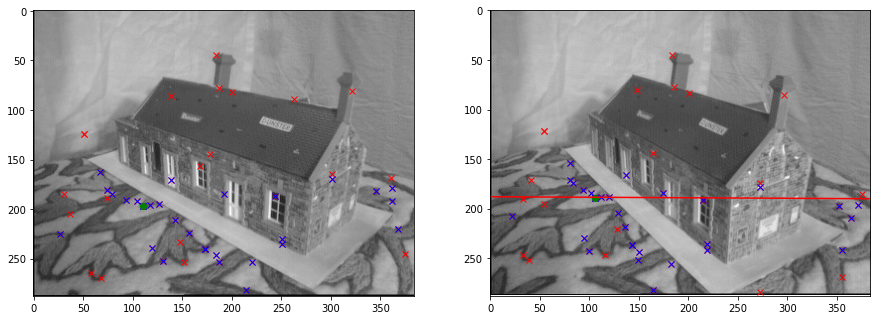

In [45]:
print(house1.shape)
print(house2.shape)

def ransacFundamental(points, thresh, minInliers, k):
    a=0
    bestError = 10000
    bestF = np.identity(3)
    bestInlrs1 = np.array(())
    bestInlrs2 = np.array(())

    pointsL = points[:,0:2]
    pointsR = points[:,2:]
    #dej v homogene
    pointsL = np.c_[pointsL, np.ones((len(pointsL)))]
    pointsR = np.c_[pointsR, np.ones((len(pointsR)))] 

    for i in range(k):
        indexesPoints = np.random.choice(len(points), size=8, replace=False)
        maybeInliersL = pointsL[indexesPoints]
        maybeInliersR = pointsR[indexesPoints]
        F,e1,e2 = fundamentalMatrix(maybeInliersL, maybeInliersR)
        inlrs1, inlrs2 = getInliers(F, pointsL, pointsR, thresh)

        #pregledas ce mas zadost inlierjov
        if len(inlrs1) >= minInliers:
            F,e1,e2 = fundamentalMatrix(inlrs1, inlrs2)
            err = averageErrorPoints(inlrs1, inlrs2, F)
            #print(err)
            if (err < bestError):
                bestError = err
                bestF = F
                bestInlrs1 = inlrs1
                bestInlrs2 = inlrs2

    return bestF, bestInlrs1, bestInlrs2, bestError


def findMatches(img1, img2, s, n):
    orb = cv2.ORB_create()

    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1,des2)

    matches = sorted(matches, key = lambda x:x.distance)



    corL = np.array([kp1[mat.queryIdx].pt for mat in matches] )
    corR = np.array([kp2[mat.trainIdx].pt for mat in matches])
    

    start = s
    end = start+n

    corL = corL[start:end]
    corR = corR[start:end]

    return corR, corR #coordinate matchov na levi in desni sliki

def findMatches2(img1, img2, strt, num):

    MIN_MATCH_COUNT = 10
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)



    corL = np.float32([kp1[m.queryIdx].pt for m in good])
    corR = np.float32([kp2[m.trainIdx].pt for m in good])
    

    corL = corL[strt:strt+num]
    corR = corR[strt:strt+num]

    return corL, corR #coordinate matchov na levi in desni sliki

def findMatchesShowPairs(img1, img2, strt=0, num=50, showPairs=True):
    MIN_MATCH_COUNT = 10
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    good = sorted(good, key=lambda x: x.distance)
    corL = np.float32([kp1[m.queryIdx].pt for m in good])
    corR = np.float32([kp2[m.trainIdx].pt for m in good])
    corL = corL[strt:strt+num]
    corR = corR[strt:strt+num]

    if showPairs: #ce hocemo se da pokaze
        #cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], img2, flags=2)
        img3  = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None)
        return corL, corR, img3
    
    return corL, corR #coordinate matchov na levi in desni sliki




corL, corR = findMatches2(house1, house2, 50, 50)

points  = np.concatenate((corL, corR),1 )
#pts1 = np.concatenate((x1, y1, x2, y2), 1)
#points  = np.concatenate((points, pts1),0 )


print(points.shape)



F, bestInlrs1, bestInlrs2, err = ransacFundamental(points, 2, 20, 100)


pointsL = points[:,0:2]
pointsR = points[:,2:]

plt.rcParams["figure.figsize"] = [15,10]
plt.subplot(121)
plt.imshow(house1, cmap="gray")


print(len(bestInlrs1), len(pointsL))


plt.subplot(122)
plt.imshow(house2, cmap="gray")
plt.rcParams["figure.figsize"] = backupPlotSize

for i in range(len(pointsL)):
    plt.subplot(121)
    plt.plot(pointsL[i,0], pointsL[i,1], 'rx')
    
    plt.subplot(122)
    plt.plot(pointsR[i,0], pointsR[i,1], 'rx')

for i in range(len(bestInlrs1)):
    plt.subplot(121)
    plt.plot(bestInlrs1[i,0], bestInlrs1[i,1], 'bx')
    
    plt.subplot(122)
    plt.plot(bestInlrs2[i,0], bestInlrs2[i,1], 'bx')


selPoint = np.random.randint(0,len(bestInlrs1))
plt.subplot(121)
plt.plot(bestInlrs1[selPoint,0], bestInlrs1[selPoint,1], 'go')
coordPoint = bestInlrs1[selPoint,:]
#epipolar line for second image
l2 = F.T@coordPoint #KLE GA TRANSPONIRAS !
height, width = house2.shape
plt.subplot(122)
plt.plot(bestInlrs2[selPoint,0], bestInlrs2[selPoint,1], 'go')
draw_epiline(l2,height, width)



## 3. Triangulate

In [46]:
def vecToMat(x):
    A= [ [0, -x[2], x[1]], [x[2], 0 , -x[0]],  [-x[1], x[0] ,0 ]]
    return np.array(A)
    

def triangulate(pts1, pts2, cal1, cal2):
    #dej v homogene
    pts1 = np.c_[pts1, np.ones((len(pts1)))]
    pts2 = np.c_[pts2, np.ones((len(pts2)))]

    triangulatedPts = np.zeros((len(pts1),4))

    for i in range(len(pts1)):
        x1x = vecToMat(pts1[i])
        x2x = vecToMat(pts2[i])

        #first two lines of [x1_x]P1 and [x2_x]P2 are matrix
        prod1 =(x1x@cal1)
        prod2 = (x2x@cal2)

        #print("p1: ", prod1)
        #print("p2: ", prod2 )

        A=np.zeros((4,4))
        A[0:2,:] = prod1[0:2,:]
        A[2:4,:] = prod2[0:2,:]

        #A=np.array([[prod1[0:2,:]], [prod1[0:2,:]]])
        #print("mat", A)
        u, s, vh = np.linalg.svd(A, full_matrices=True)

        vh = vh.T
        x=vh[:,-1]
        x=x/x[-1]
        #print("Eigv:", x, i)

        triangulatedPts[i,:] = x

    return triangulatedPts

        

house1Camera=np.loadtxt("data/epipolar/house1_camera.txt")
house2Camera=np.loadtxt("data/epipolar/house2_camera.txt")

points=np.loadtxt("data/epipolar/house_points.txt")
pointsL = points[:,0:2]
pointsR = points[:,2:]


triangulate(pointsL, pointsR, house1Camera, house2Camera)





array([[-0.09166688,  1.54113218, -5.11130385,  1.        ],
       [-1.88807782,  1.93602158, -6.11569419,  1.        ],
       [ 0.99410415,  0.74757258, -4.53449655,  1.        ],
       [-1.93040713,  1.41271217, -6.26803211,  1.        ],
       [ 0.59865299, -0.0197476 , -4.23708094,  1.        ],
       [-2.17552195,  0.6922716 , -5.95135797,  1.        ],
       [ 1.17866644, -1.09147294, -4.26309857,  1.        ],
       [-2.26557196, -0.19020358, -6.4001194 ,  1.        ],
       [-1.55759405,  0.10608691, -7.69230933,  1.        ],
       [-2.20802126,  0.46724741, -6.13054434,  1.        ]])

In [ ]:
t = np.zeros((5,3))
t[1,:] = np.ones(3)
t

array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

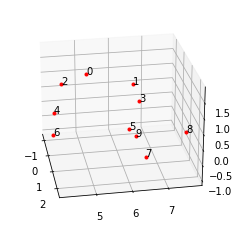

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # define 3D subplot
res = triangulate(pointsL, pointsR, house1Camera, house2Camera) # calculate 3D coordinates

T = np.array([[-1,0,0],[0,0,1],[0,-1,0]]) # transformation matrix
res = np.dot(res[:,0:3],T)

for i, pt in enumerate(res):
    plt.plot([pt[0]],[pt[1]],[pt[2]],'r.') # plot points
    ax.text(pt[0],pt[1],pt[2], str(i)) # plot indices

ax.view_init(25, -10)


In [56]:
def triangulate2(pts1, pts2, cal1, cal2):
    #dej v homogene
    pts1 = np.c_[pts1, np.ones((len(pts1)))]
    pts2 = np.c_[pts2, np.ones((len(pts2)))]

    triangulatedPts = np.zeros((len(pts1),3))

    for i in range(len(pts1)):
        x1x = vecToMat(pts1[i])
        x2x = vecToMat(pts2[i])

        #first two lines of [x1_x]P1 and [x2_x]P2 are matrix
        prod1 =(x1x@cal1)
        prod2 = (x2x@cal2)

        #print("p1: ", prod1)
        #print("p2: ", prod2 )

        A=np.zeros((4,3))
        A[0:2,:] = prod1[0:2,:]
        A[2:4,:] = prod2[0:2,:]

        #A=np.array([[prod1[0:2,:]], [prod1[0:2,:]]])
        #print("mat", A)
        u, s, vh = np.linalg.svd(A, full_matrices=True)

        vh = vh.T
        x=vh[:,-1]
        x=x/x[-1]
        #print("Eigv:", x, i)

        triangulatedPts[i,:] = x

    return triangulatedPts

### Dodatna

0.14996402654929966 (3, 3) 1 13 13


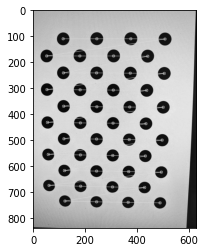

In [48]:
cal1 = cv2.imread("cal/cal10.jpg", cv2.IMREAD_GRAYSCALE)
ret, val = cv2.findCirclesGrid(cal1, (4,11), flags=cv2.CALIB_CB_ASYMMETRIC_GRID)

cal1.shape
val.shape

drawn1 = cv2.drawChessboardCorners(cal1, (4,11), val, ret)

plt.imshow(drawn1, cmap="gray")

path = "cal/"

def get_grid():
	objectPoints= []
	grid_size = 0.035 # 3.5 cm
	rows, cols = 4, 11

	for i in range(cols):
		for j in range(rows):
			objectPoints.append( (i*grid_size, (2*j + i%2)*grid_size, 0) )

	objectPoints = np.array(objectPoints).astype('float32')

	return objectPoints

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []

objp = get_grid()


for filename in os.listdir(path):
    image = cv2.imread(path + filename, cv2.IMREAD_GRAYSCALE)
    ret, val = cv2.findCirclesGrid(image, (4,11), flags=cv2.CALIB_CB_ASYMMETRIC_GRID)
    drawn1 = cv2.drawChessboardCorners(image, (4,11), val, ret)
    plt.imshow(drawn1, cmap="gray")
    #plt.show()

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(val)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[::-1],None,None)

print(ret, mtx.shape, len(dist), len(rvecs), len(tvecs))

#print(objps.shape)


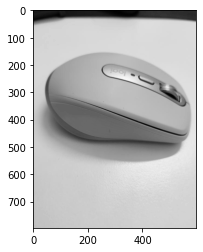

(3, 3)


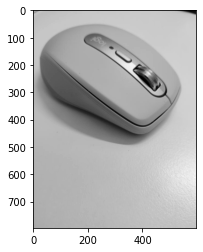

In [71]:
left =  cv2.imread("left2.jpg", cv2.IMREAD_GRAYSCALE)

h,  w = left.shape
newcameramtxL, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
dst = cv2.undistort(left, mtx, dist, None, newcameramtxL)
# crop the image, da nimas unga k okol robov mal zavije
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst, cmap="gray")
plt.show()



right =  cv2.imread("right2.jpg", cv2.IMREAD_GRAYSCALE)

h,  w = right.shape
newcameramtxR, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
dst2 = cv2.undistort(right, mtx, dist, None, newcameramtxR)
# crop the image
x,y,w,h = roi
dst2 = dst2[y:y+h, x:x+w]

print(newcameramtxR.shape)

plt.imshow(dst2, cmap="gray")
plt.show()





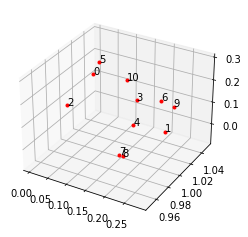

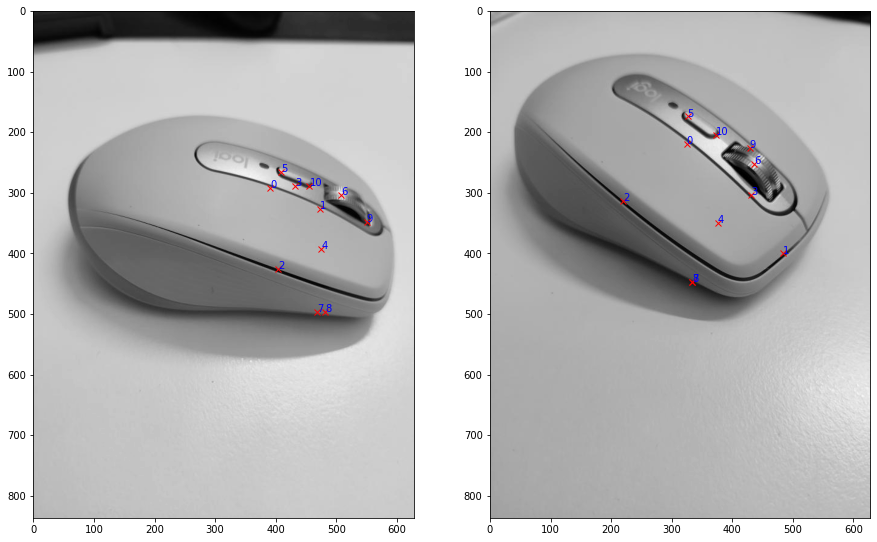

In [80]:
corL, corR = findMatches2(left, right, 0, 20)
points  = np.concatenate((corL, corR),1 )


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # define 3D subplot
res = triangulate2(corL, corR, newcameramtxL, newcameramtxR) # calculate 3D coordinates


Tf = np.array([[-1,0,0],[0,0,1],[0,-1,0]]) # transformation matrix
res = np.dot(res[:,0:3],-Tf)


for i, pt in enumerate(res):
    plt.plot([pt[0]],[pt[1]],[pt[2]],'r.') # plot points
    ax.text(pt[0],pt[1],pt[2], str(i)) # plot indices


plt.show()

plt.rcParams["figure.figsize"] = [15,10]
plt.subplot(121)
plt.imshow(left, cmap="gray")

plt.subplot(122)
plt.imshow(right, cmap="gray")


for i in range(len(corL)):
    plt.subplot(121)
    plt.plot(corL[i,0], corL[i,1], 'rx')
    plt.text(corL[i,0], corL[i,1], i, color="blue")
    
    plt.subplot(122)
    plt.plot(corR[i,0], corR[i,1], 'rx')
    plt.text(corR[i,0], corR[i,1], i, color="blue")

plt.rcParams["figure.figsize"] = backupPlotSize